# Philips' fingerprinting algorithm

References: 
- Code: https://github.com/dafg05/pitch-robust-fingerprinting/tree/main
- Cited paper: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8919347&tag=1

In [1]:
import librosa
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.spatial import distance

In [2]:
db_path = "database_recordings"
filename = "classical.00000"

In [3]:
orig_x, orig_sr = librosa.load(f"{db_path}/{filename}.wav")

In [4]:
orig_sr

22050

In [5]:
len(orig_x)

661794

In [6]:
orig_x

array([-0.02008057, -0.01748657,  0.00418091, ...,  0.01934814,
        0.027771  ,  0.03131104], dtype=float32)

In [7]:
"""
Since the algorithm only takes into account frequencies
below 2kHz the received audio is first down sampled to a mono
audio stream with a sampling rate of 5kHz
"""
sr = 5000
x = librosa.resample(orig_x, orig_sr=orig_sr, target_sr=sr)

In [8]:
len(x)

150067

In [69]:
def get_melspec(file_path, overlap_factor=64):
    
    orig_x, orig_sr = librosa.load(f"{file_path}")
    
    """
    Since the algorithm only takes into account frequencies
    below 2kHz the received audio is first down sampled to a mono
    audio stream with a sampling rate of 5kHz
    """
    sr = 5000
    x = librosa.resample(orig_x, orig_sr=orig_sr, target_sr=sr)

    """
    The audio signal is first segmented into overlapping frames. The
    overlapping frames have a length of 0.37 seconds and are
    weighted by a Hanning window with an overlap factor of 31/32.
    """
    window_size = 0.37
    hop_size = window_size/overlap_factor
    n_fft = math.ceil(window_size * sr)
    hop_len = math.ceil(hop_size * sr)
    
    """
    In order to extract a 32-bit sub-fingerprint value for every frame,
    33 non-overlapping frequency bands are selected. These bands lie
    in the range from 300Hz to 2000Hz (the most relevant spectral
    range for the HAS) and have a logarithmic spacing. 
    """
    n_mels = 33
    f_min = 300
    f_max = 2000
    
    melspec = librosa.feature.melspectrogram(y=x,
                                             sr=sr, 
                                             n_fft=n_fft, 
                                             hop_length=hop_len, 
                                             power=1, 
                                             n_mels = n_mels, 
                                             fmin = f_min, 
                                             fmax = f_max,
                                            )
    return melspec

In [21]:
overlap_factor = 32
window_size = 0.37
hop_size = window_size/overlap_factor
overlap_factor = 32
hop_len = math.ceil(hop_size * sr)
melspec = get_melspec(f"{db_path}/{filename}.wav", overlap_factor=overlap_factor)

In [22]:
melspec.shape

(33, 2588)

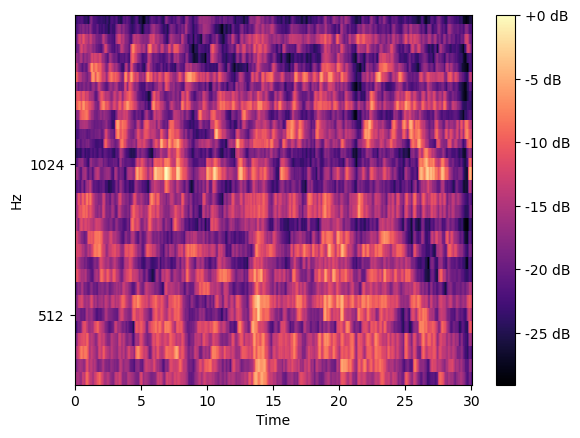

In [23]:
fig, ax = plt.subplots()
M_db = librosa.power_to_db(melspec, ref=np.max)
img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', 
                               sr=sr, 
                               n_fft=n_fft, 
                               hop_length=hop_len, 
                               fmin = f_min, 
                               fmax = f_max, 
                               ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

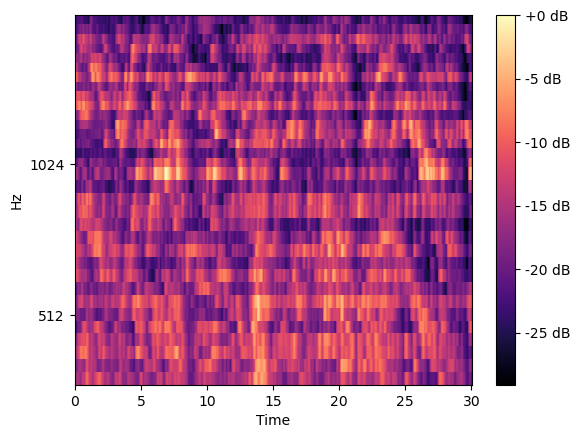

In [26]:
overlap_factor = 64
hop_size = window_size/overlap_factor
hop_len = math.ceil(hop_size * sr)
melspec = get_melspec(f"{db_path}/{filename}.wav", overlap_factor=overlap_factor)

fig, ax = plt.subplots()
M_db = librosa.power_to_db(melspec, ref=np.max)
img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', 
                               sr=sr, 
                               n_fft=n_fft, 
                               hop_length=hop_len, 
                               fmin = f_min, 
                               fmax = f_max, 
                               ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [68]:
def sub_fp_bit(n_frame, m_bit, melspec, encode=True):
    """
    Calculate sub-fingerprint bit value by taking energy band differences.

    If encode=True, return bit value in 1s and 0s.
    If not, simply return the raw value of the energy band differences.
    """
    # Transpose melspec so that x-axis corresponds to number of frames, and y_axis corresponds to number of bits
    energy_band = melspec.T
    
    # Calculate energy band differences based on formula described in paper (Equation (1) in paper)
    diff = energy_band[n_frame, m_bit] - energy_band[n_frame, m_bit+1] - (energy_band[n_frame-1, m_bit] - energy_band[n_frame-1, m_bit+1])

    if encode:
        return int(diff > 0)
    else:
        return diff
    
def get_fingerprint(melspec, encode=True):
    """
    Get fingerprint representation from a mel-spectrogram.

    Returns all the sub-fingerprints for each frame in the mel-spetrogram.
    """
    fingerprints = []
    # Iterate through every frame to get a 32-bit sub-fingerprint for each frame
    for frame_idx in range(melspec.shape[1]):
        sub_fingerprint = []
        # fill in each bit in sub-fingerprint
        for bit_idx in range(32):
            sub_fingerprint.append(sub_fp_bit(frame_idx, bit_idx, melspec, encode))
        fingerprints.append(sub_fingerprint)
    return np.array(fingerprints)
            

In [28]:
fingerprint = get_fingerprint(melspec)
fingerprint.shape

(5175, 32)

In [161]:
np.histogram(fingerprint)

(array([13937,     0,     0,     0,     0,     0,     0,     0,     0,
        13743]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

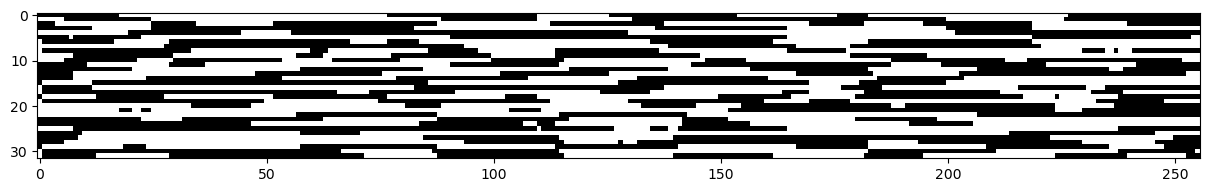

In [29]:
plt.figure(figsize=(15, 20))
plt.imshow(np.array(fingerprint[:256]).T, cmap='Greys',  interpolation='nearest')

## Load songs into database
- Convert songs to fingerprints
- Store in hash table

In [33]:
# Store fingerprints in hash table (python dictionary)
def hash_subfingerprint(sub_fp):
    """
    Converts a 32-bit sub-fingerprint to a hex representation for easy lookup.

    E.g. np.array([1, 0, 0 ,0, 0, 1, 1, 1, 1, 0,
                    0, 0, 0, 0, 1, 1, 0, 0 ,0, 0,
                    1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 
                    0, 0]) 
        is converted to '0x87830f04'
    """
    return hex(int("".join(sub_fp.astype(str)), 2))
    
def load_song_to_database(song_idx, fingerprint, lookup_dict={}):
    """
    Loads fingerprints of a single song in a hash table.
    
    Format:
    {<hashed key>: {
        <song_id1>: [frame_idx1, frame_idx2],
        <song_id2>: [frame_idx3],
        }
    Example:
    {
        "0x4be0de43": {
            'classical.00000.wav': [0],
            },
    }
    """
    for frame_idx in range(fingerprint.shape[0]):
        key = hash_subfingerprint((fingerprint[frame_idx]>0).astype(int))
        if key not in lookup_dict:
            lookup_dict[key] = {song_idx: [frame_idx]}
        elif song_idx in lookup_dict[key]:
            lookup_dict[key][song_idx].append(frame_idx)
        else:
            lookup_dict[key][song_idx] = [frame_idx]
    return lookup_dict

In [148]:
test_list = [
    'classical.00000.wav',
'classical.00003.wav',
 'pop.00013.wav',
 'pop.00065.wav',
 'pop.00070.wav',
 'pop.00069.wav',
 'classical.00050.wav',
 'classical.00085.wav',
 'classical.00084.wav',
 'pop.00054.wav',
 'classical.00049.wav',
    
]

In [224]:
# Load entire db
db_path = "database_recordings"

hash_table = {}
song_db = {}
for song_idx in os.listdir("database_recordings"):
# for song_idx in test_list:
    melspec = get_melspec(f"{db_path}/{song_idx}", overlap_factor=64)
    fingerprint =  get_fingerprint(melspec)
    song_db[song_idx] = fingerprint
    hash_table = load_song_to_database(song_idx, fingerprint, hash_table)


In [225]:
song_db.keys()

dict_keys(['classical.00017.wav', 'pop.00076.wav', 'pop.00065.wav', 'pop.00070.wav', 'pop.00066.wav', 'classical.00053.wav', 'classical.00089.wav', 'classical.00098.wav', 'pop.00054.wav', 'classical.00049.wav', 'pop.00080.wav', 'pop.00040.wav', 'classical.00012.wav', 'classical.00064.wav', 'pop.00071.wav', 'pop.00053.wav', 'classical.00077.wav', 'pop.00036.wav', 'classical.00024.wav', 'classical.00088.wav', 'classical.00046.wav', 'pop.00031.wav', 'classical.00060.wav', 'classical.00022.wav', 'pop.00012.wav', 'classical.00045.wav', 'classical.00075.wav', 'pop.00083.wav', 'pop.00017.wav', 'pop.00056.wav', 'pop.00057.wav', 'pop.00028.wav', 'pop.00025.wav', 'classical.00027.wav', 'pop.00035.wav', 'classical.00094.wav', 'pop.00008.wav', 'classical.00028.wav', 'pop.00033.wav', 'classical.00062.wav', 'pop.00052.wav', 'classical.00082.wav', 'classical.00061.wav', 'pop.00004.wav', 'pop.00003.wav', 'pop.00063.wav', 'classical.00035.wav', 'classical.00073.wav', 'classical.00039.wav', 'pop.00027.w

In [226]:
hash_table

{'0x681d2ddb': {'classical.00017.wav': [0]},
 '0x86576d9b': {'classical.00017.wav': [1, 2]},
 '0x86576ddb': {'classical.00017.wav': [3, 4]},
 '0x8e576ddb': {'classical.00017.wav': [5, 6, 7]},
 '0x8e47695b': {'classical.00017.wav': [8]},
 '0x8e6669db': {'classical.00017.wav': [9]},
 '0x4e6678db': {'classical.00017.wav': [10]},
 '0x6e6672db': {'classical.00017.wav': [11]},
 '0x6e6672d9': {'classical.00017.wav': [12, 13]},
 '0x6e6272d1': {'classical.00017.wav': [14]},
 '0x6e6372d1': {'classical.00017.wav': [15, 16]},
 '0x6e6332d1': {'classical.00017.wav': [17]},
 '0x6e633ad1': {'classical.00017.wav': [18, 19]},
 '0x6c631ad1': {'classical.00017.wav': [20]},
 '0x6c631ad5': {'classical.00017.wav': [21]},
 '0x6c619ad5': {'classical.00017.wav': [22]},
 '0x6c618ad5': {'classical.00017.wav': [23]},
 '0x6c61cad5': {'classical.00017.wav': [24, 25]},
 '0x6c69ced5': {'classical.00017.wav': [26, 27]},
 '0x6ce9ced5': {'classical.00017.wav': [28]},
 '0x6cb9cedd': {'classical.00017.wav': [29, 30]},
 '0x

In [227]:
len(hash_table)

696439

In [228]:
song_db

{'classical.00017.wav': array([[0, 1, 1, ..., 0, 1, 1],
        [1, 0, 0, ..., 0, 1, 1],
        [1, 0, 0, ..., 0, 1, 1],
        ...,
        [0, 1, 1, ..., 1, 0, 0],
        [0, 1, 1, ..., 1, 0, 1],
        [0, 1, 1, ..., 1, 0, 1]]),
 'pop.00076.wav': array([[1, 1, 1, ..., 0, 0, 1],
        [1, 1, 0, ..., 1, 0, 1],
        [1, 1, 0, ..., 1, 0, 1],
        ...,
        [1, 1, 0, ..., 0, 1, 0],
        [1, 1, 0, ..., 0, 1, 0],
        [1, 1, 0, ..., 0, 0, 0]]),
 'pop.00065.wav': array([[1, 0, 0, ..., 0, 1, 1],
        [0, 0, 1, ..., 0, 1, 1],
        [0, 0, 1, ..., 0, 1, 1],
        ...,
        [0, 0, 1, ..., 1, 1, 0],
        [1, 0, 0, ..., 1, 1, 0],
        [1, 0, 0, ..., 1, 1, 0]]),
 'pop.00070.wav': array([[1, 0, 0, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 1, 0],
        [1, 1, 1, ..., 0, 1, 0],
        ...,
        [1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 1, 1, 0]]),
 'pop.00066.wav': array([[0, 0, 1, ..., 0, 1, 1],
        [1, 1, 0, ..., 0

## Test querying
- convert query to fingerprints
- search for sub fingerprints in database

### Simple search algorithm
- calculate ber per match, get highest score per file id if there are multiple file ids
- Return first file id that meets ber threshold

In [213]:
def get_ber(query_fp, db_fp):
    """
    Calculate Bit Error Rate between 2 fingerprints.
    
    """
    total_dist = 0
    for sub_fp, db_fp in zip(query_fp, db_fp):
        total_dist += (distance.hamming(sub_fp, db_fp) * 32)  # Multiply by 32 since scipy package divides bit count by 32
    ber = total_dist/(256*32)

    return ber

In [214]:
test_list

['classical.00000.wav',
 'classical.00003.wav',
 'pop.00013.wav',
 'pop.00065.wav',
 'pop.00070.wav',
 'pop.00069.wav',
 'classical.00050.wav',
 'classical.00085.wav',
 'classical.00084.wav',
 'pop.00054.wav',
 'classical.00049.wav']

In [405]:
# Philips Search algorithm (Assumption: at least 1 sub-fingerprint with exact match)"
query_path = 'query_recordings'
song_idx = 'classical.00000-snippet-10-0.wav'
# song_idx = 'pop.00013-snippet-10-20.wav'
# k = 3   # Number of matches to return
# ber_threshold=0.47
def get_query_matches(song_idx):
    matches = {}
    
    # 1. for each query file
    # 2. Look through sub-fingerprints
    # 3. get sub-fingerprint matches against db
    # 4. Look through matches and calculate minimum BER of each block
    # 5. Return Top 3 matches ranked by min BER
    
    melspec = get_melspec(f"{query_path}/{song_idx}", overlap_factor=64)
    query_fp =  get_fingerprint(melspec)
    query_matches = []
    for sub_fp_idx in range(256, len(query_fp)):
        sub_fp = query_fp[sub_fp_idx]
        key = hash_subfingerprint(sub_fp.astype(int))
        if key in hash_table:
            print(f"Found key {key} at index {sub_fp_idx} in hash table with exact match")
            # Loop through all songs with that sub-fingerprint
            for file_id, frame_ids in hash_table[key].items():
                print(file_id)
                if matches.get(file_id) is None:
                    matches[file_id] = 1
                for frame_id in frame_ids:
                    # Check if ber meets threshold requirements
                    fp_block = song_db[file_id][frame_id-256: frame_id]
                    query_fp_blk = query_fp[sub_fp_idx-256:sub_fp_idx]
                    ber = get_ber(query_fp_blk, fp_block)
                    # Keep minimum BER only
                    matches[file_id] = min(matches[file_id], ber)

    return matches


In [ ]:
def ge

In [406]:
get_query_matches(song_idx)

Found key 0x4e54da26 at index 1045 in hash table with exact match
classical.00011.wav
491
0.531005859375
Found key 0x94b361db at index 1396 in hash table with exact match
classical.00000.wav
1389
0.3607177734375
1390
0.358642578125
1391
0.35791015625
1392
0.3580322265625


{'classical.00011.wav': 0.531005859375, 'classical.00000.wav': 0.35791015625}

In [293]:
hash_table['0x4e54da26']

{'classical.00011.wav': [491]}

In [294]:
hash_table['0x94b361db']

{'classical.00000.wav': [1389, 1390, 1391, 1392]}

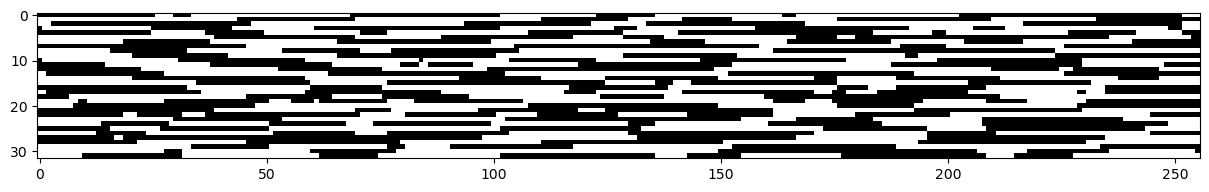

In [295]:
plt.figure(figsize=(15, 20))
plt.imshow((query_fp[1045-256:1045] > 0).astype(int).T, cmap='Greys',  interpolation='nearest')

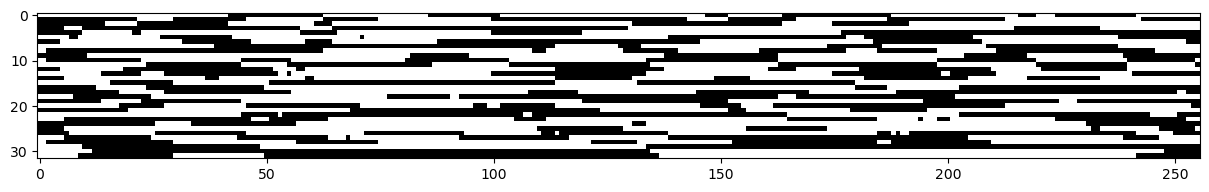

In [296]:
plt.figure(figsize=(15, 20))
plt.imshow((song_db['classical.00011.wav'][491-256:491] > 0).astype(int).T, cmap='Greys',  interpolation='nearest')

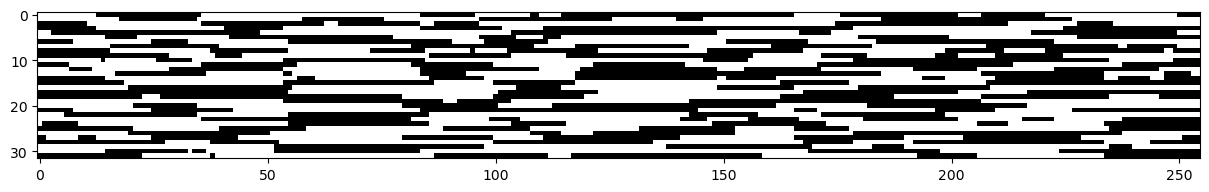

In [297]:
plt.figure(figsize=(15, 20))
plt.imshow((query_fp[1396-255:1396] > 0).astype(int).T, cmap='Greys',  interpolation='nearest')

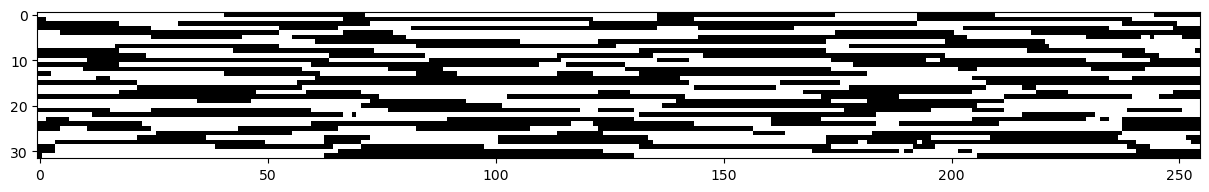

In [298]:
plt.figure(figsize=(15, 20))
plt.imshow((song_db['classical.00000.wav'][1389-255:1389] > 0).astype(int).T, cmap='Greys',  interpolation='nearest')

In [369]:
def is_matched(matches, actual, k=3):
    """
    Returns whether actual piece is found in matches as all levels of top-k

    E.g. if k=3 and piece if found at rank 2, then return [False, True, True].
    """
    match_at_k = []
    sorted_matches = sorted(matches, key=matches.get, reverse=False)
    # matched = False
    for i in range(k):
        if f"{actual.split('-')[0]}.wav" in sorted_matches[:i]:
            match_at_k.append(True)
        else:
            match_at_k.append(False)
    # for match in sorted_matches[:k]:
    #     if f"{actual.split('-')[0]}" in match:
    #         matched = True
    #     match_at_k.append(matched)
    
    return match_at_k

In [407]:
match_stats = []
# for query_file in [f"{file.split('.wav')[0]}-snippet-10-{i}.wav" for file in test_list for i in ["0", "10", "20"]]:
for query_file in os.listdir(query_path):
    print(query_file)
    matches = get_query_matches(query_file)
    match_stats.append(is_matched(matches, query_file, k=3))

pop.00055-snippet-10-20.wav
classical.00069-snippet-10-20.wav
Found key 0x96375a31 at index 1113 in hash table with exact match
classical.00051.wav
3423
0.46630859375
Found key 0x5ac35ccd at index 1172 in hash table with exact match
classical.00091.wav
3424
0.510986328125
3425
0.5101318359375
3426
0.5091552734375
3427
0.5074462890625
Found key 0x5ac35ccd at index 1173 in hash table with exact match
classical.00091.wav
3424
0.508056640625
3425
0.5084228515625
3426
0.5074462890625
3427
0.5064697265625
pop.00000-snippet-10-10.wav
Found key 0x4618cdda at index 1190 in hash table with exact match
classical.00016.wav
653
0.4649658203125
classical.00064-snippet-10-10.wav
pop.00005-snippet-10-0.wav
Found key 0xc9198e18 at index 697 in hash table with exact match
pop.00041.wav
4439
0.4630126953125
pop.00044-snippet-10-10.wav
Found key 0xa6663263 at index 1577 in hash table with exact match
pop.00046.wav
4266
0.4742431640625
Found key 0xa6663263 at index 1578 in hash table with exact match
pop.0

In [408]:
pd.DataFrame(match_stats).sum()/len(match_stats)

0    0.000000
1    0.089202
2    0.112676
dtype: float64

In [457]:
# Philips Search algorithm (Assumption: at least 1 sub-fingerprint with exact match)"
query_path = 'query_recordings'
k = 3   # Number of matches to return
matches_all = {}

# 1. for each query file
# 2. Look through sub-fingerprints
# 3. get sub-fingerprint matches against db
# 4. Look through matches and calculate minimum BER of each block
# 5. Return Top 3 matches ranked by min BER

# for query_file in ["classical.00000-snippet-10-0.wav", "classical.00000-snippet-10-10.wav", "classical.00000-snippet-10-20.wav"]:
def get_query_matches_complex(query_file):
    matches = {}
    print(query_file)
    melspec = get_melspec(f"{query_path}/{query_file}")
    query_fp =  get_fingerprint(melspec, encode=False)
    query_matches = []

    for sub_fp_idx in range(256, len(query_fp)):
        sub_fp = query_fp[sub_fp_idx]
        
        bin_fp = sub_fp > 0
        # print(bin_fp)

        key = hash_subfingerprint(bin_fp.astype(int))
        least_reliable = np.argsort(np.abs(sub_fp))

        if key in hash_table:
            query_matches.append(key)
            # print(f"Found key {key} in hash table with exact match")
            for file_id, frame_ids in hash_table[key].items():
                if matches.get(file_id) is None:
                    matches[file_id] = 1
                for frame_id in frame_ids:
                    # Check if ber meets threshold requirements
                    fp_block = song_db[file_id][frame_id-256: frame_id]
                    query_fp_blk = (query_fp > 0).astype(int)[sub_fp_idx-256:sub_fp_idx]
                    ber = get_ber(query_fp_blk, fp_block)
                    # Keep minimum BER only
                    matches[file_id] = min(matches[file_id], ber)

        # Check for least-reliable bit matches
        sec_bin_fp = bin_fp.copy()
        i = 0

        for i in range(k):

            least_conf_idx = least_reliable[i]
            sec_bin_fp[least_conf_idx] = ~sec_bin_fp[least_conf_idx]
            key = hash_subfingerprint(sec_bin_fp.astype(int))
            i += 1

            if key in hash_table:
                query_matches.append(key)
                # print(f'Found key {key} in hash table after switching {i} bits')
                for file_id, frame_ids in hash_table[key].items():
                    if matches.get(file_id) is None:
                        matches[file_id] = 1
                    for frame_id in frame_ids:
                        # Check if ber meets threshold requirements
                        fp_block = song_db[file_id][frame_id-256: frame_id]
                        query_fp_blk = (query_fp > 0).astype(int)[sub_fp_idx-256:sub_fp_idx]
                        ber = get_ber(query_fp_blk, fp_block)
                        
                        # Keep minimum BER only
                        matches[file_id] = min(matches[file_id], ber)
    return matches

        # matches_all[query_file] = matches


In [462]:
t = get_query_matches_complex('classical.00000-snippet-10-20.wav')

classical.00000-snippet-10-20.wav


In [469]:
list(t.keys())[:4]

['classical.00008.wav', 'classical.00002.wav', 'classical.00092.wav']

In [459]:
match_stats = []
# for query_file in [f"{file.split('.wav')[0]}-snippet-10-{i}.wav" for file in test_list for i in ["0", "10", "20"]]:
for query_file in os.listdir(query_path):
    print(query_file)
    matches = get_query_matches_complex(query_file)
    match_stats.append(is_matched(matches, query_file, k=3))

pop.00055-snippet-10-20.wav
pop.00055-snippet-10-20.wav
classical.00069-snippet-10-20.wav
classical.00069-snippet-10-20.wav
pop.00000-snippet-10-10.wav
pop.00000-snippet-10-10.wav
classical.00064-snippet-10-10.wav
classical.00064-snippet-10-10.wav
pop.00005-snippet-10-0.wav
pop.00005-snippet-10-0.wav
pop.00044-snippet-10-10.wav
pop.00044-snippet-10-10.wav
classical.00049-snippet-10-20.wav
classical.00049-snippet-10-20.wav
classical.00050-snippet-10-20.wav
classical.00050-snippet-10-20.wav
pop.00044-snippet-10-20.wav
pop.00044-snippet-10-20.wav
pop.00010-snippet-10-0.wav
pop.00010-snippet-10-0.wav
pop.00040-snippet-10-0.wav
pop.00040-snippet-10-0.wav
pop.00059-snippet-10-10.wav
pop.00059-snippet-10-10.wav
classical.00070-snippet-10-0.wav
classical.00070-snippet-10-0.wav
pop.00085-snippet-10-0.wav
pop.00085-snippet-10-0.wav
classical.00044-snippet-10-20.wav
classical.00044-snippet-10-20.wav
pop.00013-snippet-10-20.wav
pop.00013-snippet-10-20.wav
classical.00040-snippet-10-10.wav
classica

In [461]:
pd.DataFrame(match_stats).sum()/len(match_stats)

0    0.000000
1    0.140845
2    0.192488
dtype: float64